In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import gym

In [122]:
class ActorCriticNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCriticNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
     
    def forward(self, observation):
        return self.network(observation)

In [123]:
env = gym.make('LunarLander-v2')

print("Possible actions:", env.action_space.n)
print("Possible states:")

Possible actions: 4
Possible states:


In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device to be used:", device)

Device to be used: cuda


In [125]:
actor = ActorCriticNN(env.observation_space.shape[0], env.action_space.n).to(device)
critic = ActorCriticNN(env.observation_space.shape[0], 1).to(device)

In [126]:
# Hyperparameters
learning_rate = 0.00001
gamma = 0.99 # for calculating cumulative rewards
print_rate = 50 # rate that the output will be printed

In [127]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate)

In [128]:
def update_networks(new_state, reward, done, state, action_prob):
    not_done = 1 - int(done)
    
    new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)

    qvalue = critic(state)
    qvalue_new = critic(new_state)
    
    td_error = reward + gamma*qvalue_new*not_done - qvalue
    objective = -1*torch.log(action_prob)*td_error
    
    loss = torch.pow(td_error, 2) + objective 
    
    loss.backward()
    
    actor_optimizer.step()
    critic_optimizer.step()
    
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()

In [129]:
print_rate = 10 # rate that the output will be printed


rewards_history = []

def train(env, n_episodes=30):
    
    for episode in range(n_episodes):
        done = False
        state = env.reset()
        rewards_episode = 0
        
        while not done:
            state = torch.tensor(state, dtype=torch.float32, device=device)
            action_probs = F.softmax(actor(state))
            action = torch.distributions.Categorical(action_probs).sample()
            
            new_state, reward, done, info = env.step(int(action))
            
            update_networks(new_state, reward, done, state, action_probs[int(action)])
            
            state = new_state
            rewards_episode += reward
            
        print("Episode {} \t rewards:{:.4f}".format(episode, rewards_episode)) 
        rewards_history.append(rewards_episode)

In [134]:
train(env, 2000)

/home/elisio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 0 	 rewards:239.4113
Episode 1 	 rewards:187.6922
Episode 2 	 rewards:-48.6904
Episode 3 	 rewards:213.8447
Episode 4 	 rewards:213.7947
Episode 5 	 rewards:59.2669
Episode 6 	 rewards:-31.0080
Episode 7 	 rewards:182.1692
Episode 8 	 rewards:-220.2138
Episode 9 	 rewards:79.1570
Episode 10 	 rewards:56.0967
Episode 11 	 rewards:246.3789
Episode 12 	 rewards:-96.7891
Episode 13 	 rewards:253.6478
Episode 14 	 rewards:223.8793
Episode 15 	 rewards:-121.1906
Episode 16 	 rewards:200.5796
Episode 17 	 rewards:85.7880
Episode 18 	 rewards:184.1781
Episode 19 	 rewards:-160.5278
Episode 20 	 rewards:212.3114
Episode 21 	 rewards:-139.1911
Episode 22 	 rewards:185.5275
Episode 23 	 rewards:254.3207
Episode 24 	 rewards:103.4995
Episode 25 	 rewards:190.9654
Episode 26 	 rewards:239.5862
Episode 27 	 rewards:150.3707
Episode 28 	 rewards:-30.3964
Episode 29 	 rewards:-22.8264
Episode 30 	 rewards:3.5011
Episode 31 	 rewards:53.0035
Episode 32 	 rewards:-205.3764
Episode 33 	 rewards:2

Episode 268 	 rewards:208.3580
Episode 269 	 rewards:209.1738
Episode 270 	 rewards:137.3292
Episode 271 	 rewards:221.2883
Episode 272 	 rewards:-185.8853
Episode 273 	 rewards:175.8657
Episode 274 	 rewards:-29.3933
Episode 275 	 rewards:128.2174
Episode 276 	 rewards:243.8427
Episode 277 	 rewards:-49.9096
Episode 278 	 rewards:191.1157
Episode 279 	 rewards:-190.7631
Episode 280 	 rewards:171.2322
Episode 281 	 rewards:-34.2896
Episode 282 	 rewards:254.1411
Episode 283 	 rewards:26.5113
Episode 284 	 rewards:204.3840
Episode 285 	 rewards:129.2580
Episode 286 	 rewards:-37.4748
Episode 287 	 rewards:223.8323
Episode 288 	 rewards:129.1669
Episode 289 	 rewards:-124.8298
Episode 290 	 rewards:0.0665
Episode 291 	 rewards:241.7694
Episode 292 	 rewards:10.0644
Episode 293 	 rewards:-92.8993
Episode 294 	 rewards:-18.5115
Episode 295 	 rewards:269.3923
Episode 296 	 rewards:-29.7883
Episode 297 	 rewards:259.5233
Episode 298 	 rewards:190.3347
Episode 299 	 rewards:155.4977
Episode 3

Episode 533 	 rewards:94.2457
Episode 534 	 rewards:112.4785
Episode 535 	 rewards:-17.2341
Episode 536 	 rewards:32.3553
Episode 537 	 rewards:237.1257
Episode 538 	 rewards:215.6871
Episode 539 	 rewards:-10.6934
Episode 540 	 rewards:198.1589
Episode 541 	 rewards:213.2129
Episode 542 	 rewards:190.2281
Episode 543 	 rewards:196.9997
Episode 544 	 rewards:-192.7580
Episode 545 	 rewards:217.0567
Episode 546 	 rewards:177.6657
Episode 547 	 rewards:18.2427
Episode 548 	 rewards:-4.8843
Episode 549 	 rewards:213.5845
Episode 550 	 rewards:205.7734
Episode 551 	 rewards:228.7357
Episode 552 	 rewards:242.0766
Episode 553 	 rewards:210.9431
Episode 554 	 rewards:205.2541
Episode 555 	 rewards:166.7688
Episode 556 	 rewards:-8.7167
Episode 557 	 rewards:-165.0940
Episode 558 	 rewards:213.3903
Episode 559 	 rewards:233.6119
Episode 560 	 rewards:19.7854
Episode 561 	 rewards:227.9516
Episode 562 	 rewards:182.2545
Episode 563 	 rewards:237.6281
Episode 564 	 rewards:222.4413
Episode 565 

Episode 798 	 rewards:201.1630
Episode 799 	 rewards:175.7416
Episode 800 	 rewards:28.7615
Episode 801 	 rewards:226.8179
Episode 802 	 rewards:-147.8181
Episode 803 	 rewards:223.9340
Episode 804 	 rewards:35.8025
Episode 805 	 rewards:182.6796
Episode 806 	 rewards:232.0497
Episode 807 	 rewards:258.7147
Episode 808 	 rewards:248.8706
Episode 809 	 rewards:223.2759
Episode 810 	 rewards:227.1765
Episode 811 	 rewards:266.0938
Episode 812 	 rewards:134.6821
Episode 813 	 rewards:-9.0205
Episode 814 	 rewards:240.1246
Episode 815 	 rewards:234.7032
Episode 816 	 rewards:135.8149
Episode 817 	 rewards:-32.3117
Episode 818 	 rewards:4.8634
Episode 819 	 rewards:0.4868
Episode 820 	 rewards:207.1061
Episode 821 	 rewards:13.1182
Episode 822 	 rewards:244.9980
Episode 823 	 rewards:249.8416
Episode 824 	 rewards:156.2998
Episode 825 	 rewards:0.0754
Episode 826 	 rewards:254.4884
Episode 827 	 rewards:56.9457
Episode 828 	 rewards:248.9971
Episode 829 	 rewards:231.7263
Episode 830 	 rewa

Episode 1062 	 rewards:15.4048
Episode 1063 	 rewards:265.0952
Episode 1064 	 rewards:239.4149
Episode 1065 	 rewards:285.2266
Episode 1066 	 rewards:235.0785
Episode 1067 	 rewards:221.8241
Episode 1068 	 rewards:88.7841
Episode 1069 	 rewards:218.7977
Episode 1070 	 rewards:88.9505
Episode 1071 	 rewards:263.7357
Episode 1072 	 rewards:237.5168
Episode 1073 	 rewards:13.6321
Episode 1074 	 rewards:1.8296
Episode 1075 	 rewards:6.5544
Episode 1076 	 rewards:229.7452
Episode 1077 	 rewards:219.5203
Episode 1078 	 rewards:188.4673
Episode 1079 	 rewards:121.1134
Episode 1080 	 rewards:180.6344
Episode 1081 	 rewards:228.6721
Episode 1082 	 rewards:249.0292
Episode 1083 	 rewards:179.2043
Episode 1084 	 rewards:145.7408
Episode 1085 	 rewards:196.0831
Episode 1086 	 rewards:254.4608
Episode 1087 	 rewards:11.9391
Episode 1088 	 rewards:20.9975
Episode 1089 	 rewards:248.0518
Episode 1090 	 rewards:181.1806
Episode 1091 	 rewards:262.6192
Episode 1092 	 rewards:157.9424
Episode 1093 	 rew

Episode 1320 	 rewards:239.9445
Episode 1321 	 rewards:157.7084
Episode 1322 	 rewards:269.9486
Episode 1323 	 rewards:216.1705
Episode 1324 	 rewards:276.1024
Episode 1325 	 rewards:35.4131
Episode 1326 	 rewards:220.1389
Episode 1327 	 rewards:220.2269
Episode 1328 	 rewards:197.8786
Episode 1329 	 rewards:-35.0065
Episode 1330 	 rewards:46.9339
Episode 1331 	 rewards:143.3567
Episode 1332 	 rewards:230.2533
Episode 1333 	 rewards:25.6933
Episode 1334 	 rewards:299.2741
Episode 1335 	 rewards:167.1644
Episode 1336 	 rewards:230.9184
Episode 1337 	 rewards:278.8535
Episode 1338 	 rewards:-106.5093
Episode 1339 	 rewards:-26.6286
Episode 1340 	 rewards:231.2753
Episode 1341 	 rewards:239.5713
Episode 1342 	 rewards:212.2756
Episode 1343 	 rewards:265.0210
Episode 1344 	 rewards:70.1676
Episode 1345 	 rewards:127.9242
Episode 1346 	 rewards:225.8127
Episode 1347 	 rewards:-14.1996
Episode 1348 	 rewards:219.9559
Episode 1349 	 rewards:251.9490
Episode 1350 	 rewards:19.2486
Episode 1351

Episode 1578 	 rewards:168.1105
Episode 1579 	 rewards:279.2886
Episode 1580 	 rewards:195.2109
Episode 1581 	 rewards:46.6615
Episode 1582 	 rewards:-48.6052
Episode 1583 	 rewards:298.4773
Episode 1584 	 rewards:50.4661
Episode 1585 	 rewards:232.1401
Episode 1586 	 rewards:227.2658
Episode 1587 	 rewards:9.2688
Episode 1588 	 rewards:-12.8691
Episode 1589 	 rewards:28.5730
Episode 1590 	 rewards:-74.0096
Episode 1591 	 rewards:218.3853
Episode 1592 	 rewards:256.3651
Episode 1593 	 rewards:222.8630
Episode 1594 	 rewards:176.4568
Episode 1595 	 rewards:118.9903
Episode 1596 	 rewards:-56.9549
Episode 1597 	 rewards:189.4662
Episode 1598 	 rewards:182.8431
Episode 1599 	 rewards:244.5121
Episode 1600 	 rewards:291.2995
Episode 1601 	 rewards:210.7870
Episode 1602 	 rewards:206.4539
Episode 1603 	 rewards:306.8915
Episode 1604 	 rewards:271.2226
Episode 1605 	 rewards:156.2692
Episode 1606 	 rewards:188.9976
Episode 1607 	 rewards:29.5587
Episode 1608 	 rewards:237.5964
Episode 1609 	

Episode 1836 	 rewards:19.5019
Episode 1837 	 rewards:270.3495
Episode 1838 	 rewards:19.4596
Episode 1839 	 rewards:-54.9269
Episode 1840 	 rewards:165.2430
Episode 1841 	 rewards:248.7059
Episode 1842 	 rewards:152.4846
Episode 1843 	 rewards:92.6815
Episode 1844 	 rewards:4.3002
Episode 1845 	 rewards:221.9010
Episode 1846 	 rewards:258.7451
Episode 1847 	 rewards:147.9057
Episode 1848 	 rewards:125.7500
Episode 1849 	 rewards:58.1142
Episode 1850 	 rewards:190.7935
Episode 1851 	 rewards:-29.6813
Episode 1852 	 rewards:281.4652
Episode 1853 	 rewards:-81.9815
Episode 1854 	 rewards:-23.3200
Episode 1855 	 rewards:144.6770
Episode 1856 	 rewards:-132.2377
Episode 1857 	 rewards:206.8926
Episode 1858 	 rewards:233.5471
Episode 1859 	 rewards:271.4842
Episode 1860 	 rewards:220.3804
Episode 1861 	 rewards:48.4403
Episode 1862 	 rewards:192.5400
Episode 1863 	 rewards:240.2091
Episode 1864 	 rewards:126.2868
Episode 1865 	 rewards:27.6066
Episode 1866 	 rewards:53.5392
Episode 1867 	 r

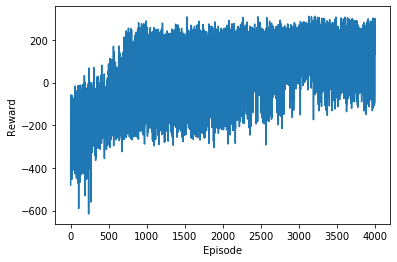

In [135]:
plt.plot(rewards_history)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()